### Solve IK for `Common Rig H EmotionMocap` 

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,r2quat,rpy2R
import pickle

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse `scene_common_rig_h.xml`

In [2]:
# xml_path = '../asset/myo_sim/myolegs_v0.56(mj237).mjb'
xml_path = '../asset/common_rig/scene_common_rig_v2.xml'
env = MuJoCoParserClass(name='myosuite',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0083] HZ:[120]
n_dof (=nv):[41]
n_geom:[26]
geom_names:['floor', 'base', 'root2spine', 'spine2neck', 'neck2rshoulder', 'neck2lshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rthumb', 'rpalm', 'lshoulder2lelbow', 'lelbow2lwrist', 'lthumb', 'lpalm', 'head', 'nose', 'base2rpelvis', 'rpelvis2rknee', 'rknee2rankle', 'rankle', 'rfoot', 'base2lpelvis', 'lpelvis2lknee', 'lknee2lankle', 'lankle', 'lfoot']
n_body:[20]
body_names:['world', 'base', 'torso', 'spine', 'neck', 'right_shoulder', 'right_elbow', 'right_hand', 'left_shoulder', 'left_elbow', 'left_hand', 'head', 'right_leg', 'right_pelvis', 'right_knee', 'right_ankle', 'left_leg', 'left_pelvis', 'left_knee', 'left_ankle']
n_joint:[36]
joint_names:['base', 'root1', 'root2', 'root3', 'spine', 'rs1', 'rs2', 'rs3', 're', 'rw1', 'rw2', 'rw3', 'ls1', 'ls2', 'ls3', 'le', 'lw1', 'lw2', 'lw3', 'head1', 'head2', 'head3', 'rp1', 'rp2', 'rp3', 'rk', 'ra1', 'ra2', 'ra3', 'lp1', 'lp2', 'lp3', 'lk', 'la1', 'la2', 'la3']
joint_types:[0 3 3 3 3 3 3

In [4]:
def np_uv(vec):
    """
        Get unit vector
    """
    x = np.array(vec)
    return x/np.linalg.norm(x)

# Lower body only
def get_uv_dict_cmu(p):
    uv_dict = {}

    # Lower Body
    uv_dict['Hips2RightUpLeg'] = np_uv([0,-0.18,0])# np_uv(p[27,:] - p[0,:])
    uv_dict['RightUpLeg2RightLeg'] = np_uv(p[28,:] - p[27,:])
    uv_dict['RightLeg2RightFoot'] = np_uv(p[29,:] - p[28,:])
    uv_dict['RightFoot2RightToeBase'] = np_uv(p[30,:] - p[29,:])
    uv_dict['Hips2LeftUpLeg'] = np_uv([0,+0.18,0])# np_uv(p[33,:] - p[0,:])
    uv_dict['LeftUpLeg2LeftLeg'] = np_uv(p[34,:] - p[33,:])
    uv_dict['LeftLeg2LeftFoot'] = np_uv(p[35,:] - p[34,:])
    uv_dict['LeftFoot2LeftToeBase'] = np_uv(p[36,:] - p[35,:])
    
    # Upper Body
    # uv_dict['pelvis2torso'] = np_uv(p[9,:] - p[0,:])
    # uv_dict['torso2humerus_r'] = np_uv(p[17,:] - p[9,:])
    # uv_dict['humerus_r2radius'] = np_uv(p[18,:] - p[17,:])
    # uv_dict['radius2lunate'] = np_uv(p[19,:] - p[18,:])
    # uv_dict['torso2humerus_l'] = np_uv(p[45,:] - p[9,:])
    # uv_dict['humerus_l2radius_l'] = np_uv(p[46,:] - p[45,:])
    # uv_dict['radius_l2lunate_l'] = np_uv(p[47,:] - p[46,:])

    return uv_dict

def get_p_target_common_rig_cmu(p, uv_dict):
    len_rig = {}
    # len_rig['root2spine'] = 0.1990
    # len_rig['spine2neck'] = 0.1990
    # len_rig['neck2rs'] = 0.1809
    # len_rig['rs2re'] = 0.2768
    # len_rig['re2rw'] = 0.1815
    # len_rig['neck2ls'] = 0.1809
    # len_rig['ls2le'] = 0.2768
    # len_rig['le2lw'] = 0.1815
    len_rig['root2rp'] = 0.1357
    len_rig['rp2rk'] = 0.4049
    len_rig['rk2ra'] = 0.4057
    len_rig['root2lp'] = 0.1357
    len_rig['lp2lk'] = 0.4049
    len_rig['lk2la'] = 0.4057

    p_target = {}
    p_target['right_pelvis'] = p[0,:] + len_rig['root2rp'] * uv_dict['Hips2RightUpLeg']
    p_target['right_knee'] = p_target['right_pelvis'] + len_rig['rp2rk'] * uv_dict['RightUpLeg2RightLeg']
    p_target['right_ankle'] = p_target['right_knee'] + len_rig['rk2ra'] * uv_dict['RightLeg2RightFoot']
    p_target['left_pelvis'] = p[0,:] + len_rig['root2lp'] * uv_dict['Hips2LeftUpLeg']
    p_target['left_knee'] = p_target['left_pelvis'] + len_rig['lp2lk'] * uv_dict['LeftUpLeg2LeftLeg']
    p_target['left_ankle'] = p_target['left_knee'] + len_rig['lk2la'] * uv_dict['LeftLeg2LeftFoot']
    # p_target['spine'] = p[0,:] + len_rig['root2spine'] * uv_dict['root2spine']

   
    return p_target

def get_p_target_myolegs_cmu(p, uv_dict):
    len_rig = {}
    # len_rig['root2spine'] = 0.1990
    # len_rig['spine2neck'] = 0.1990
    # len_rig['neck2rs'] = 0.1809
    # len_rig['rs2re'] = 0.2768
    # len_rig['re2rw'] = 0.1815
    # len_rig['neck2ls'] = 0.1809
    # len_rig['ls2le'] = 0.2768
    # len_rig['le2lw'] = 0.1815
    len_rig['root2rp'] = 0.1357
    len_rig['rp2rk'] = 0.4049
    len_rig['rk2ra'] = 0.4057
    len_rig['root2lp'] = 0.1357
    len_rig['lp2lk'] = 0.4049
    len_rig['lk2la'] = 0.4057

    p_target = {}
    p_target['right_pelvis'] = p[0,:] + len_rig['root2rp'] * uv_dict['Hips2RightUpLeg']
    p_target['right_knee'] = p_target['right_pelvis'] + len_rig['rp2rk'] * uv_dict['RightUpLeg2RightLeg']
    p_target['right_ankle'] = p_target['right_knee'] + len_rig['rk2ra'] * uv_dict['RightLeg2RightFoot']
    p_target['left_pelvis'] = p[0,:] + len_rig['root2lp'] * uv_dict['Hips2LeftUpLeg']
    p_target['left_knee'] = p_target['left_pelvis'] + len_rig['lp2lk'] * uv_dict['LeftUpLeg2LeftLeg']
    p_target['left_ankle'] = p_target['left_knee'] + len_rig['lk2la'] * uv_dict['LeftLeg2LeftFoot']
    # p_target['spine'] = p[0,:] + len_rig['root2spine'] * uv_dict['root2spine']

   
    return p_target



In [3]:
env.open_interactive_viewer()

2023-12-20 13:10:12.794 python[34076:363798] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


### Target BVH

In [5]:
with open(file='data.pickle', mode='rb') as f:
    data=pickle.load(f)

p_full = data['p']
r_full = data['R']

frame_number = 0
p = p_full[frame_number]
r = r_full[frame_number]

uv_dict = get_uv_dict_cmu(p)
p_target = get_p_target_common_rig_cmu(p, uv_dict)

### Set IK targets (`24` in total: `10` for body & `14` for hands)

In [6]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common Rig CMU',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
env.reset()

# Set which joints to control
ctrl_joint_names = env.ctrl_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

env.body_names
ik_body_names = ['right_pelvis','right_knee','right_ankle','left_pelvis','left_knee','left_ankle'
                #  ,'spine','neck','right_shoulder','right_elbow','right_hand','left_shoulder','left_elbow','left_hand'
                 ]

ik_target_indices = [1,2,3,5,6,7
                    #  ,11,13,17,18,19,45,46,47
                     ]

IK_Ps = [True]*len(ik_body_names)
IK_Rs = [False]*len(ik_body_names)

ik_p_trgts = []
ik_R_trgts = []

for body in ik_body_names:
    ik_p_trgts.append(p_target[body])

for i in ik_target_indices:
    ik_R_trgts.append(r[i])

### Loop

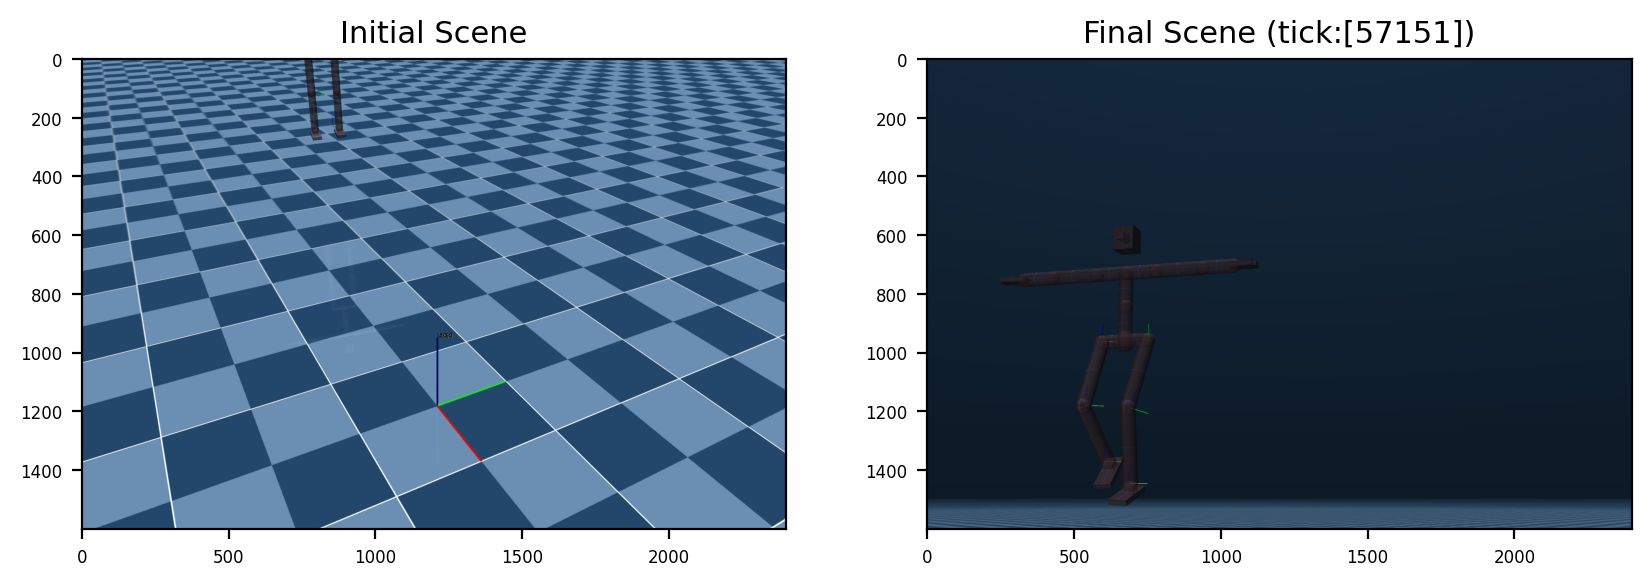

In [8]:
# Reset and loop 
q = q_ctrl_init.copy()

# # Good starting position
# init_joint_names = ['rs1','rs2','rs3','ls1','ls2','ls3','re','le']
# q_init = np.radians([70,25,-5,-70,-25,-5,35,-35])
# joint_idxs_init = [env.model.joint(jname).qposadr[0] for jname in init_joint_names]
# env.forward(q=q_init,joint_idxs=joint_idxs_init)

PERTURB_BASE_POSITION = True
if PERTURB_BASE_POSITION:
    jntadr = env.model.body('base').jntadr[0]
    qposadr = env.model.jnt_qposadr[jntadr]
    base_pos = p[0] # modify base position
    env.data.qpos[qposadr:qposadr+3] = base_pos
    env.data.qpos[qposadr+3:qposadr+7] = r2quat(r[0])

FIRST_FLAG = True
while env.is_viewer_alive():
    
    # Solve inverse kinematics
    J_list,ik_err_list = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        ik_p_trgt = ik_p_trgts[ik_idx]
        ik_R_trgt = ik_R_trgts[ik_idx]
        IK_P = IK_Ps[ik_idx]
        IK_R = IK_Rs[ik_idx]
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=IK_P,IK_R=IK_R)
        J_list.append(J)
        ik_err_list.append(ik_err)
    J_stack      = np.vstack(J_list)
    ik_err_stack = np.hstack(ik_err_list)
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]
    
    # FK
    env.data.qpos[joint_idxs_fwd] = q
    q_couple = env.data.qpos.copy()

    env.forward(q=q_couple,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # Text information
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
                   label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        env.plot_body_T(body_name='base',PLOT_AXIS=False,axis_len=0.5,axis_width=0.01)
        for body_name in env.body_names:
            p,R = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p,R=R,PLOT_AXIS=False,axis_len=0.05,axis_width=0.005)
            
        # Plot IK target
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            # env.plot_body_T(body_name=ik_body_name,
                            # PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)
            env.plot_T(p=ik_p_trgt,R=ik_R_trgt,
                       PLOT_AXIS=True,axis_len=0.1,axis_width=0.002)
        
        # Plot revolute joints with arrow
        # for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
        #     axis_joint = env.model.jnt_axis[rev_joint_idx]
        #     p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
        #     axis_world = R_joint@axis_joint
        #     axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
        #     axis_len,axis_r = 0.1,0.01
        #     env.plot_arrow_fr2to(
        #         p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
        #         r=axis_r,rgba=axis_rgba)
            
        # Plot contact information
        # env.plot_contact_info(h_arrow=0.01,rgba_arrow=[1,0,0,0.01],r_sphere=0.005,
        #                       PRINT_CONTACT_BODY=True)
        env.render()

    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False
        
# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()

### Entire Sequence

In [11]:
import numpy as np
import pickle
from bvh.skeleton import process_bvhfile, process_bvhkeyframe

with open(file='data.pickle', mode='rb') as f:
    data=pickle.load(f)

p_full = data['p']
r_full = data['R']

num_frames = p_full.shape[0]

qpos_data = np.zeros((num_frames, env.data.qpos.shape[0]))

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common Rig CMU',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])

for timestep in range(num_frames):
    p = p_full[timestep]
    r = r_full[timestep]

    uv_dict = get_uv_dict_cmu(p)
    p_target = get_p_target_common_rig_cmu(p, uv_dict)

    env.reset()

    # Set which joints to control
    ctrl_joint_names = env.ctrl_names # <==
    joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
    joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
    q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
    n_ctrl_joint = len(ctrl_joint_names)

    ik_body_names = ['right_pelvis','right_knee','right_ankle','left_pelvis','left_knee','left_ankle',
                    #  'spine','neck','right_shoulder','right_elbow','right_hand','left_shoulder','left_elbow','left_hand',
                    ]
    ik_target_indices = [1,2,3,5,6,7,
                        #  11,13,17,18,19,45,46,47,
                         ]

    IK_Ps = [True]*len(ik_body_names)
    IK_Rs = [False]*len(ik_body_names)
    ik_p_trgts = []
    ik_R_trgts = []

    for body in ik_body_names:
        ik_p_trgts.append(p_target[body])

    for i in ik_target_indices:
        ik_R_trgts.append(r[i])

    # Reset and loop 
    q = q_ctrl_init.copy()

    PERTURB_BASE_POSITION = True
    if PERTURB_BASE_POSITION:
        jntadr = env.model.body('base').jntadr[0]
        qposadr = env.model.jnt_qposadr[jntadr]
        base_pos = p[0] # modify base position
        env.data.qpos[qposadr:qposadr+3] = base_pos
        env.data.qpos[qposadr+3:qposadr+7] = r2quat(r[0])

    FIRST_FLAG = True
    while env.tick < 500:
        
        # Solve inverse kinematics
        J_list,ik_err_list = [],[]
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            IK_P = IK_Ps[ik_idx]
            IK_R = IK_Rs[ik_idx]
            J,ik_err = env.get_ik_ingredients(
                body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                IK_P=IK_P,IK_R=IK_R)
            J_list.append(J)
            ik_err_list.append(ik_err)
        J_stack      = np.vstack(J_list)
        ik_err_stack = np.hstack(ik_err_list)
        dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
        q = q + dq[joint_idxs_jac]
        
        # FK
        env.data.qpos[joint_idxs_fwd] = q
        q_couple = env.data.qpos.copy()

        env.forward(q=q_couple,INCREASE_TICK=True)
        # env.render()

    qpos_data[timestep,:] = np.array(q_couple)
    print("Timestep: ", timestep)

# Close MuJoCo viewer
env.close_viewer()

p_root = p_full[:,0,:]

pkl_data = {
    'length': num_frames,
    'root': p_root,
    'qpos': qpos_data
}



Timestep:  0
Timestep:  1
Timestep:  2
Timestep:  3
Timestep:  4
Timestep:  5
Timestep:  6
Timestep:  7
Timestep:  8
Timestep:  9
Timestep:  10
Timestep:  11
Timestep:  12
Timestep:  13
Timestep:  14
Timestep:  15
Timestep:  16
Timestep:  17
Timestep:  18
Timestep:  19
Timestep:  20
Timestep:  21
Timestep:  22
Timestep:  23
Timestep:  24
Timestep:  25
Timestep:  26
Timestep:  27
Timestep:  28
Timestep:  29
Timestep:  30
Timestep:  31
Timestep:  32
Timestep:  33
Timestep:  34
Timestep:  35
Timestep:  36
Timestep:  37
Timestep:  38
Timestep:  39
Timestep:  40
Timestep:  41
Timestep:  42
Timestep:  43
Timestep:  44
Timestep:  45
Timestep:  46
Timestep:  47
Timestep:  48
Timestep:  49
Timestep:  50
Timestep:  51
Timestep:  52
Timestep:  53
Timestep:  54
Timestep:  55
Timestep:  56
Timestep:  57
Timestep:  58
Timestep:  59
Timestep:  60
Timestep:  61
Timestep:  62
Timestep:  63
Timestep:  64
Timestep:  65
Timestep:  66
Timestep:  67
Timestep:  68
Timestep:  69
Timestep:  70
Timestep:  71
Ti

In [12]:
with open('../data/common_rig_cmu_walk.pkl', 'wb') as f:
    pickle.dump(pkl_data, f)

: 

In [ ]:
pkl_path = '../data/common_rig_cmu_walk.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)


In [ ]:
data